<a href="https://colab.research.google.com/github/nichakornchaisuwan/Project_Boneage/blob/main/Toy_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is an attempt to predict bone age using Xception(pre trained model)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra # เป็นการ import numpy เพื่อเปิดใช้ฟังก์ชันในการทำงาน
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) # เป็น library ในการจัดการ dataframe
import tensorflow as tf #library สำหรับสร้าง machine learning models แบบ open source จาก Google
import datetime,os # datetime ใช้ในการจัด format ของวัน-เวลาให้อยู่ในรูปแบบที่ต้องการ 
import math # เรียกใช้ module เพื่อคำนวณค่าต่างๆ 
import matplotlib.pyplot as plt # เป็น module พื้นฐานที่ใช้ในการสร้างกราฟของ python
import seaborn as sns # เป็นฟังก์ชันเสริมที่ใช้สร้างกราฟให้มีความสวยงามมากขึ้น
from sklearn.model_selection import train_test_split # เป็น library ในการพัฒนาโปรแกรมโดยใช้การเรียนรู้ของเครื่อง

In [ ]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์

In [ ]:
path = '/content/drive/My Drive/Project_Boneage'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

# ***Some Setup***

The cell below creates the pandas dataframes for training and testing.

In [ ]:
#loading dataframes # เอาที่อยู่ของไฟล์เชื่อมกับที่อยู่ของไฟล์เรา โดยกำหนดชื่่อไฟล์ที่เราต้องการ
train_path = os.path.join(path,'boneage-training-dataset.csv')
train_df = pd.read_csv(train_path)
test_path = os.path.join(path,'boneage-test-dataset.csv')
test_df = pd.read_csv(test_path)

In [ ]:
train_df # แสดง data 'train_df'

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
12606,15605,50,False
12607,15606,113,False
12608,15608,55,False
12609,15609,150,True


In [ ]:
test_df # แสดง data 'test_df'

,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M
3,4363,M
4,4364,M
...,...,...
195,4555,F
196,4556,F
197,4557,F
198,4558,F


In [ ]:
#appending file extension to id column for both training and testing dataframes
# ต่อท้าย data ใน column 'id' ด้วย .png
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png') # ทำการเปลี่ยน type ใน column 'id' จาก int  เป็น string เพื่อให้สามารถต่อท้ายด้วย .png ได้ # ฟังก์ชันแลมบ์ดาเป็นฟังก์ชันที่ไม่ระบุตัวตนขนาดเล็ก
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head() # แสดงค่าของ train_df บางส่วน

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


# Some EDA and feature engineering follow

In [ ]:
#finding out the number of male and female children in the dataset
#creating a new column called gender to keep the gender of the child as a string
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female') # ทำการเปลี่ยนค่าข้อมูล gender จาก true -> male, false -> female 
train_df['gender']

0        female
1        female
2        female
3          male
4        female
          ...  
12606    female
12607    female
12608    female
12609      male
12610      male
Name: gender, Length: 12611, dtype: object

In [ ]:
print(train_df['gender'].value_counts()) #แสดงจำนวนเพศหญิงและเพศชายทั้งหมดใน trian_df

male      6833
female    5778
Name: gender, dtype: int64


In [ ]:
train_df.shape # ข้อมูลมีทั้งหมด 12611 จากทั้งหมด 4 column

(12611, 4)

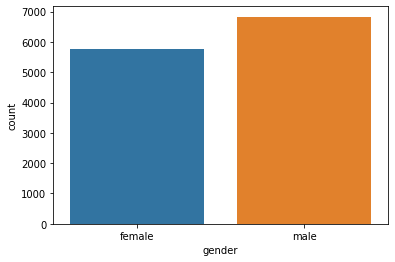

In [ ]:
sns.countplot(x = train_df['gender']) # plot กราฟแสดงจำนวนเพศหญิงและเพศชายทั้งหมดใน trian_df

In [ ]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months') # ทำการหาอายุที่มากที่สุด และทำการต่อท้ายด้วย months

MAX age: 228 months


In [ ]:
#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')  # ทำการหาอายุที่น้อยที่สุด และทำการต่อท้ายด้วย months

MIN age: 1 months


In [ ]:
#mean age is # หาค่าเฉลี่ยอายุกระดูก
mean_bone_age = train_df['boneage'].mean() 
print('mean: ' + str(mean_bone_age))

mean: 127.3207517246848


In [ ]:
#median bone age # หาค่า median ของอายุกระดูก
print('median: ' +str(train_df['boneage'].median()))

median: 132.0


In [ ]:
#standard deviation of boneage # หาค่าส่วนเบี่ยงเบนมาตรฐานของอายุกระดูก
std_bone_age = train_df['boneage'].std()
std_bone_age

41.182021399396326

In [ ]:
#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training 
# ทำการหาค่า z-score 
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)
print(train_df.head())

         id  boneage   male  gender  bone_age_z
0  1377.png      180  False  female    1.279181
1  1378.png       12  False  female   -2.800269
2  1379.png       94  False  female   -0.809109
3  1380.png      120   True    male   -0.177766
4  1381.png       82  False  female   -1.100498


Text(0.5, 1.0, 'Number of children in each age group')

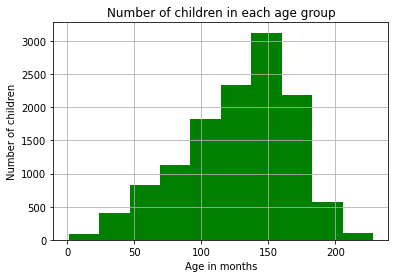

In [ ]:
#plotting a histogram for bone ages # plot กราฟ เพื่อดูการกระจายของอายุกระดูก
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

Text(0.5, 1.0, 'Relationship between number of children and bone age z score')

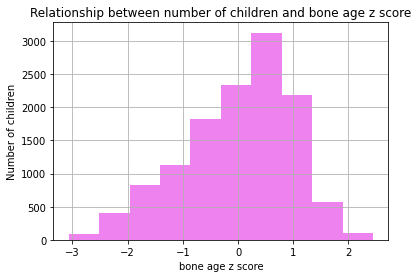

In [ ]:
train_df['bone_age_z'].hist(color = 'violet') # plot กราฟ เพื่อดูการกระจายค่า z-score ของอายุกระดูก
plt.xlabel('bone age z score')
plt.ylabel('Number of children')
plt.title('Relationship between number of children and bone age z score')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 86.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 87.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


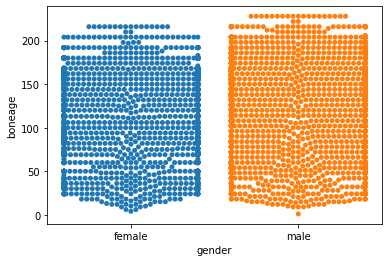

In [ ]:
#Relationship between age and gender with a categorical scatter plot (swarmplot) # plot ดูความสัมพันธ์ระหว่างอายุและเพศ
# swarmplot ใช้ plot เพื่อดูการกระจายของข้อมูลโดยที่จุดไม่ทับซ้อนกัน
sns.swarmplot(x = train_df['gender'], y = train_df['boneage'])

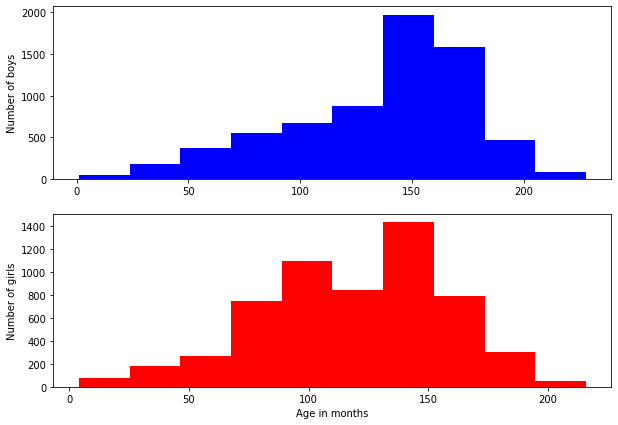

In [ ]:
#distribution of age within each gender # plot การกระจายอายุกระดูกของแต่ละเพศ
male = train_df[train_df['gender'] == 'male']
female = train_df[train_df['gender'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue')
ax[0].set_ylabel('Number of boys')
ax[1].hist(female['boneage'], color = 'red')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('Number of girls')
fig.set_size_inches((10,7))

In [ ]:
#splitting train dataframe into traininng and validation dataframes #แบ่งข้อมูลออกเป็น 2 ส่วน ด้วยการสุ่ม
df_train, df_valid = train_test_split(train_df, test_size = 0.2, random_state = 0) 
# test_size = 0.2 คือ สัดส่วนของข้อมูลที่ใช้ในการทดสอบ (หากไม่มีการกำหนดค่าจะถูก set = 0.25)# random_state ใช้ในการสุ่มแบ่งกลุ่ม (default=None)

In [ ]:
df_train # training

,id,boneage,male,gender,bone_age_z
8079,10538.png,132,False,female,0.113624
7248,9608.png,168,True,male,0.987791
204,1607.png,162,True,male,0.842097
10651,13424.png,162,True,male,0.842097
9283,11898.png,168,True,male,0.987791
...,...,...,...,...,...
4859,6961.png,60,True,male,-1.634712
3264,5198.png,106,False,female,-0.517720
9845,12527.png,120,False,female,-0.177766
10799,13593.png,144,False,female,0.405013


In [ ]:
df_valid # validation

,id,boneage,male,gender,bone_age_z
5112,7239.png,94,False,female,-0.809109
9866,12548.png,174,True,male,1.133486
2760,4640.png,144,False,female,0.405013
6184,8432.png,168,True,male,0.987791
6803,9121.png,108,True,male,-0.469155
...,...,...,...,...,...
10027,12722.png,150,True,male,0.550708
5928,8150.png,132,False,female,0.113624
5354,7509.png,144,False,female,0.405013
8548,11062.png,156,False,female,0.696402


In [ ]:
import matplotlib.image as mpimg

In [ ]:
import os  
from PIL import Image
import matplotlib.image as mpimg

In [ ]:
#data_image = os.path.join(path,'boneage-training-dataset') #เอาพาร์ทที่อยู่ในไฟล์มาเชื่อมกับColab
#print(data_image)

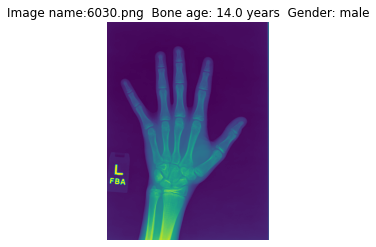

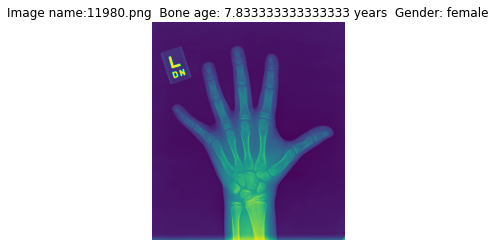

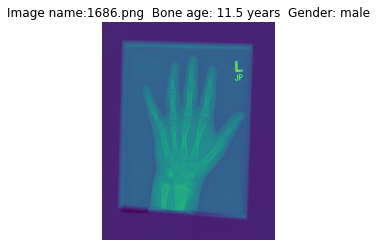

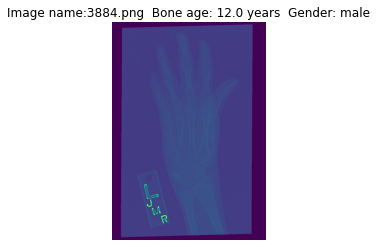

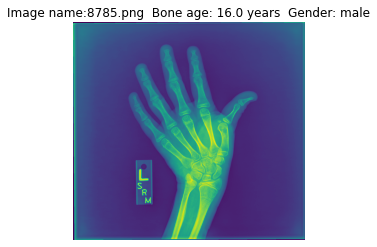

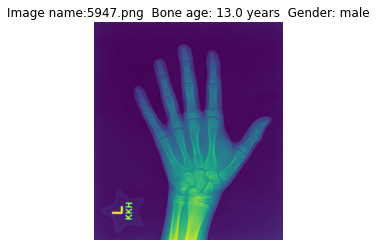

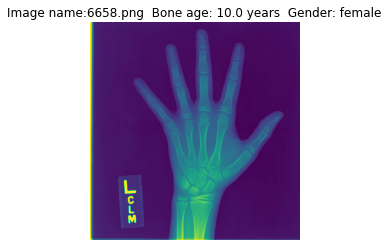

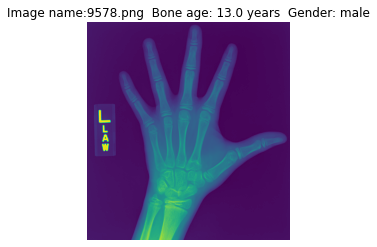

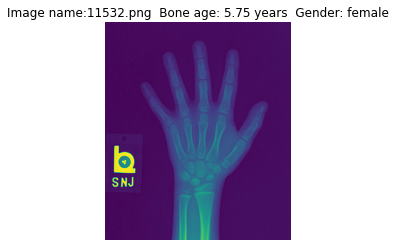

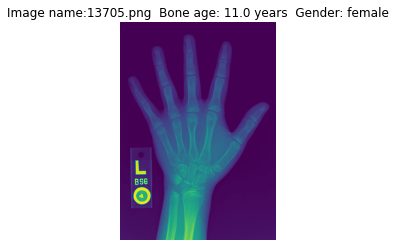

In [ ]:
import matplotlib.image as mpimg #นำเข้า library ที่ใช้อ่านรูป
for filename, boneage, gender in train_df[['id','boneage','gender']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    img = mpimg.imread(os.path.join(path,'boneage-training-dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.imshow(img) # แสดงรูปภาพ
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.axis('off')
    plt.show()

In [ ]:
#library required for image preprocessing #นำเข้า library ที่ใช้ในการประมวลผลรูปภาพ
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from  keras.applications.xception import preprocess_input 

In [ ]:
#reducing down the size of the image 
img_size = 256 # ปรับขนาดรูปภาพ

## Linkเนื้อหาเพิ่มเติม

* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

* https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1

* https://www.toppr.com/guides/python-guide/references/methods-and-functions/methods/built-in/next/python-next/#:~:text=The%20python%20next%20function%20is%20used%20to%20return%20the%20next,the%20StopIteration%20exception%20will%20arise.


In [ ]:
#preprocessing_function ฟังก์ชันที่จะนำไปใช้กับแต่ละอินพุต ฟังก์ชันจะทำงานหลังจากปรับขนาดและเพิ่มรูปภาพแล้ว

In [ ]:
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input) #สร้างตัวแปร train_data_generator เพื่อเก็บข้อมูลการประมวลผลล่วงหน้าของ tensor หรือ array Numpy ที่เข้ารหัสชุดของรูปภาพ
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)  #สร้างตัวแปร val_data_generator เพื่อเก็บข้อมูลการประมวลผลล่วงหน้าของ tensor หรือ array Numpy ที่เข้ารหัสชุดของรูปภาพ

In [ ]:
#train data generator 
train_generator = train_data_generator.flow_from_dataframe( # .flow_from_dataframe() เป็นตัวช่วยในการจับคู่ dataframe ระหว่างชื่อของไฟล์รูปภาพกับป้ายกำกับ 
    dataframe = df_train, #ข้อมูลที่อยู่ในรูปแบบของตาราง
     directory = (os.path.join(path,'boneage-training-dataset/')), #directory คือ การจัดเก็บไฟล์คอมพิวเตอร์ โดยจะใช้ path เพื่อชี้ไปยังที่ที่เก็บข้อมูลอยู่
    x_col= 'id', #การป้อนข้อมูล โดยข้อมูลที่ใช้ คือ ID
    y_col= 'bone_age_z', # ข้อมูลเป้าหมาย
    batch_size = 32, # จำนวนตัวอย่างต่อชุดการคำนวณ มีค่า default = 32
    seed = 42,  # มีค่าเป็น Int (default: None)
    shuffle = True, # เป็น Boolean หรือ String ซึ่งจะละเว้นเมื่อ x เป็นตัวตั้งต้นในการ train ข้อมูล ในการจัดการกับข้อจำกัดของข้อมูล hdf5(.h5) ให้เปลี่ยนเป็นขนาดแบทช์
    class_mode= 'other', # เป็นการกำหนดหมวดหมู่ ประเภทของ array ที่มีการส่งข้อมูลกลับมา
    flip_vertical = True, # เป็น Boolean ที่ทำการสุ่มพลิก input ในแนวตั้ง
    color_mode = 'rgb', #การกำหนดสี rgb คือแม่สี , rgba คือแม่สีที่สามารถกำหนดค่าความโปร่งแสงได้
    target_size = (img_size, img_size)) # ขนาดของรูปภาพที่เรากำหนดใหม่ img_height, img_width

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 10088 validated image filenames.


In [ ]:
#validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = (os.path.join(path,'boneage-training-dataset/')),
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 2523 validated image filenames.


In [ ]:
#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory( # .flow_from_directory เป็นตัวช่วยในการอ่านรูปภาพจากโฟลเดอร์ต่างๆ
    directory = (os.path.join(path,'boneage-test-dataset/')),
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

Found 0 images belonging to 0 classes.


In [ ]:
#import matplotlib.image as mpimg #นำเข้า library ที่ใช้อ่านรูป
#for filename, gender in test_df[['Case ID','Sex']].values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ เพศ)
    #img = mpimg.imread(os.path.join(path,'boneage-test-dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    #plt.imshow(img) # แสดงรูปภาพ
    #plt.title('Image name:{}    Gender: {}'.format(filename, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ และเพศ ของแต่ละภาพ
    #plt.axis('off')
    #plt.show()

In [ ]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe(  #next ใช้เพื่อส่งคืนรายการถัดไปจากตัววนซ้ำ
                            df_valid, # ตาราง validation
                            directory = (os.path.join(path,'boneage-training-dataset/')),
                            x_col = 'id',
                            y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 2523,
                            class_mode = 'other'
                            ))

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 2523 validated image filenames.


In [ ]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [ ]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p): #เป็นการเขียนฟังก์ชั่นเพื่อคืนค่า mean_absolute_error ของ x,y 
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age))

In [ ]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten  # .layers เป็นโมดูล API สำหรับ Namespace , GlobalMaxPooling2D เป็นโอเปอเรชั่นสำหรับข้อมูลเชิงพื้นที่ , Dense เป็นเลเยอร์ NN ที่เชื่อมต่ออย่างหนาแน่นปกติ,Flatten เป็นการปรับ input ให้เรียบ โดยที่ไม่มีผลกับขนาดแบทช์
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau # .callbacks เป็นโมดูล API สำหรับ Namespace,TensorBoard เป็นการใช้งานสำหรับแสดงภาพ, ModelCheckpoint เป็นการบันทึกโมเดล keras หรือ รุ่นน้ำหนักที่ความถี่บางอย่าง,EarlyStopping เป็นการหยุดการฝึกเมื่อตัววัดที่ตรวจสอบหยุดการปรับปรุง,ReduceLROnPlateau เป็นการลดอัตราการเรียนรู้ เมื่อตัววัดหยุดการปรับปรุง
from tensorflow.keras import Sequential #การจัดกลุ่ม stack เชิงเส้นของเลเยอร์ (ให้คุณสมบัติการฝึกอบรม และการอนุมานในโมเดล)

In [ ]:
model_1 = tf.keras.applications.xception.Xception(input_shape = (img_size, img_size, 3), # เป็นการสร้าง Instantiates สถาปัตยากรรมของ xception โดย xception คือการเรียนรู้เชิงลึกด้วยคอนโวลูชันแยกจากกันในเชิงลึก
                                           include_top = False, # เป็นการรวมเลเยอร์ที่เชื่อมต่ออย่างสมบูรณ์
                                           weights = 'imagenet')  # คือน้ำหนักที่เริ่มต้นด้วยการสุ่ม โดย imagenet คือการฝึกล่วงหน้าบน imageNet
model_1.trainable = True
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(10, activation = 'relu'))
model_2.add(Dense(1, activation = 'linear'))


#compile model 
model_2.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] ) # เป็นการกำหนดค่าโมเดลสำหรับการฝึก, loss คือฟังก์ชันการสูญเสีย, optimizer เครื่องมือเพิ่มประสิทธิภาพที่ใช้อัลกอริทึมของ Adam, metrics ใช้ในการประเมินตัวแบบในระหว่างการฝึกอบรมและการทดสอบ
 
#model summary
model_2.summary() # ใช้แสดงค่าของโมเดล

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20,881,981
Trainable params: 20,827,453
Non

In [ ]:
# Load the TensorBoard notebook extension 
%load_ext tensorboard 
logs_dir = '.\logs'

In [ ]:
import tensorflow as tf
import datetime, os

In [ ]:
#early stopping #EarlyStopping เป็นการหยุดการฝึกเมื่อตัววัดที่ตรวจสอบหยุดการปรับปรุง
early_stopping = EarlyStopping(monitor='val_loss', # ปริมาณที่ต้องการติดตาม
                              min_delta=0, #การเปลี่ยนแปลงขั้นต่ำในปริมาณที่ตรวจสอบ เพื่อให้มีคุณสมบัติในการปรับปรุง 
                              patience= 5, #จำนวนยุคที่ไม่มีการปรับปรุงหลังจากนั้นจะหยุดการฝึก
                              verbose=0, mode='auto') # เป็นโหมดความฟุ่มเฟือย โดยที่ 0 คือ เงียบ และ 1 จะแสดงข้อความเมื่อมีการcallback mode คือการฝึกอบรมจะหยุดเมื่อปริมาณที่ตรวจสอบหยุดลดลง
early_stopping

In [ ]:
#model checkpoint #ModelCheckpoint เป็นการบันทึกโมเดล keras หรือ รุ่นน้ำหนักที่ความถี่บางอย่าง
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True) # save_best_only ระบบบันทึกเฉพาะเมื่อแบบจำลองนั้นถือว่าดีที่สุด
mc

In [ ]:
#tensorboard callback #TensorBoard เป็นการใช้งานสำหรับแสดงภาพ
logdir = os.path.join(logs_dir,datetime.datetime.now().strftime('%Y%m%d-%H%M%S')) # logs_dir คือเส้นทางของไดเรกเทอรี่ที่ใช้บันทึกไฟล์เพื่อนำไปแยกวิเคราะห์ใน tensorboard
tensorboard_callback =  TensorBoard(logdir, histogram_freq = 1) #histogram_freq คือความถี่ที่จะคำนวณ histigram น้ำหนัก สำหรับเลเยอร์ของแบบจำลอง
tensorboard_callback

In [ ]:
#reduce lr on plateau #ReduceLROnPlateau เป็นการลดอัตราการเรียนรู้ เมื่อตัววัดหยุดการปรับปรุง
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
red_lr_plat # factor คือปัจจัยที่ทำให้การเรียนรู้ลดลง new_lr = lr*factor, cooldown คือจำนวนครั้งที่รอก่อนที่จะกลับมาทำงานตามปกติหลังจากลดค่า lr แล้ว ,min_lr คือขอบล่างของอัตราการเรียนรู้

In [ ]:
callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]
callbacks

In [ ]:
#fit model 
history = model_2.fit(train_generator, #
                            steps_per_epoch = 315,#จำนวนขั้นตอนทั้งหมด (กลุ่มตัวอย่าง) ก่อนการประกาศยุคหหนึ่งเสร็จสิ้นและเริ่มยุคถัดไปเมื่อฝึกกับ tensor input 
                            validation_data = val_generator,# ข้อมูลที่ใช้ในการประเมินความสูญเสีย และตัววัดแบบจำลองใดๆ เมื่อสิ้นสุดแต่ละยุคซึ่งโมเดลจะไม่ได้รับการฝึกอบรมเกี่ยวกับข้อมูลนี้
                            validation_steps = 1, # หากมีการระบุ 'validation_steps' จะใช้เพียงส่วนหนึ่งของชุดข้อมูล การประเมินจะเริ่มจากจุดเริ่มต้นของชุดข้อมูลในแต่ละยุค 
                            epochs = 50, # จำนวนที่ใช้ในการฝึกโมเดล
                            callbacks= callbacks) #ใช้ระหว่างการฝึกอบรม ซึ่งจะถูกสร้างขึ้นโดยอัตโนมัติและไม่จำเป็นต้องส่งผ่านเข้าไป
history
%tensorboard --logdir logs
plot_it(history)

Epoch 1/50
315/315 [==============================] - 7673s 24s/step - loss: 0.4460 - mae_in_months: 20.2665 - val_loss: 0.1970 - val_mae_in_months: 16.1630 - lr: 0.0010
Epoch 2/50
315/315 [==============================] - 7629s 24s/step - loss: 0.1459 - mae_in_months: 12.4047 - val_loss: 0.2239 - val_mae_in_months: 16.0250 - lr: 0.0010
Epoch 3/50
315/315 [==============================] - 7638s 24s/step - loss: 0.1087 - mae_in_months: 10.7293 - val_loss: 0.1669 - val_mae_in_months: 13.7025 - lr: 0.0010
Epoch 4/50
315/315 [==============================] - 7758s 25s/step - loss: 0.0872 - mae_in_months: 9.5692 - val_loss: 0.1538 - val_mae_in_months: 13.2929 - lr: 0.0010
Epoch 5/50
315/315 [==============================] - 7894s 25s/step - loss: 0.0667 - mae_in_months: 8.3485 - val_loss: 0.1507 - val_mae_in_months: 12.3625 - lr: 0.0010
Epoch 6/50
110/315 [=========>....................] - ETA: 1:25:25 - loss: 0.0468 - mae_in_months: 6.9940

In [ ]:
model_2.load_weights('best_model.h5')
pred = mean_bone_age + std_bone_age*(model_2.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

In [ ]:
ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months, pred, 'r.', label = 'predictions')
ax.plot(test_months, test_months, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

In [ ]:
test_generator.reset()
y_pred = model_2.predict_generator(test_generator)
predicted = y_pred.flatten()
predicted_months = mean_bone_age + std_bone_age*(predicted)
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions": predicted_months})
results.to_csv("results.csv",index=False)